/scratch/slurm_tmpdir/job_1509288/ipykernel_3626395/1499021325.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_excel(excel_filepath, parse_dates=date_cols)



Duplicate entries detected:
        ID                                               name  \
42    4033  Chinese state-sponsored TAG-112 compromised Ti...   
42    4033  Chinese state-sponsored TAG-112 compromised Ti...   
55    4003  Russian State-Sponsored Hacker Group Noname057...   
55    4003  Russian State-Sponsored Hacker Group Noname057...   
79    3966  Russian hackers gained access to the network o...   
...    ...                                                ...   
3354   960                                    Operation Wocao   
3360   967                      MSS 2020 Indictment Case 2017   
3360   967                      MSS 2020 Indictment Case 2017   
3360   967                      MSS 2020 Indictment Case 2017   
3360   967                      MSS 2020 Indictment Case 2017   

                                            description start_date  \
42    On or around 23 May 2024, Chinese state-sponso... 2024-05-23   
42    On or around 23 May 2024, Chinese state-spon

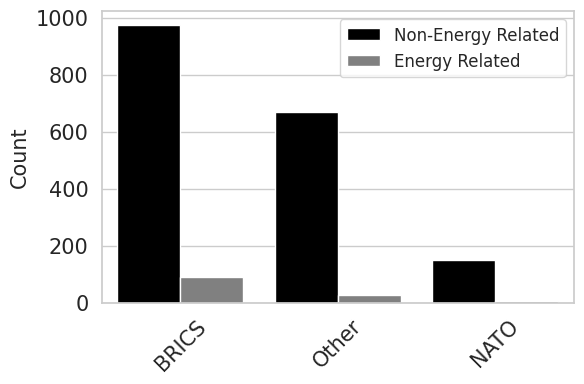

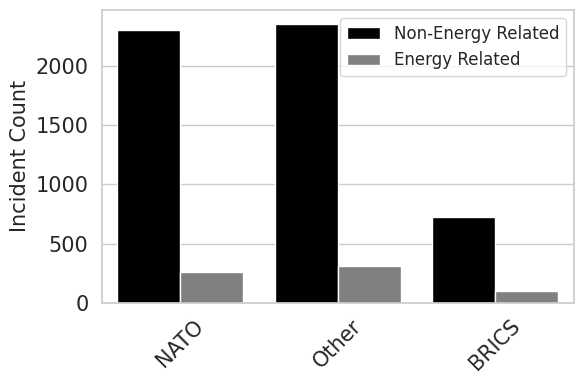

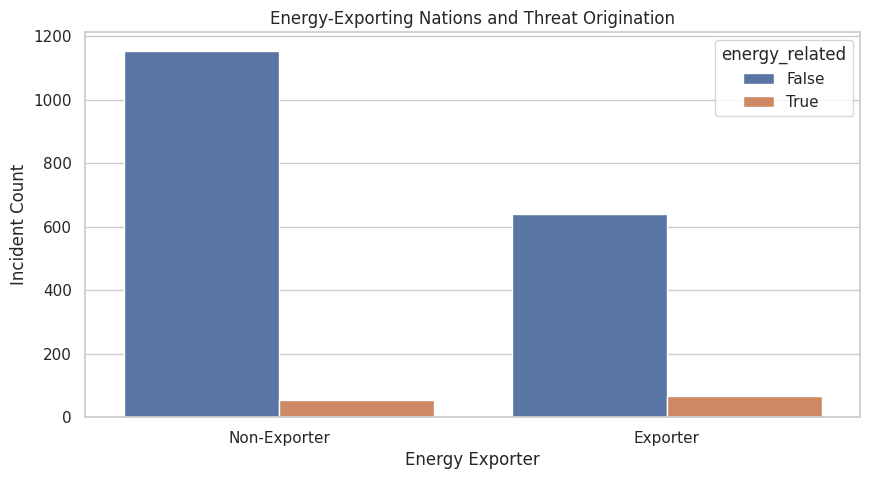

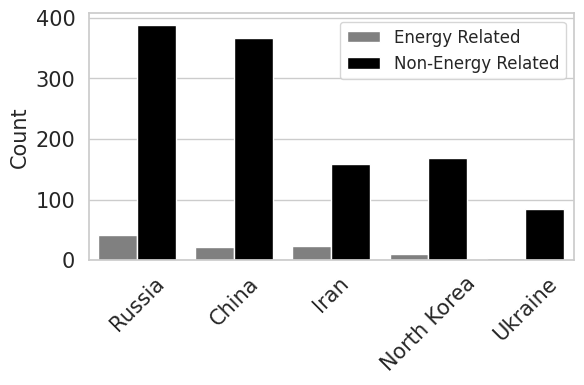

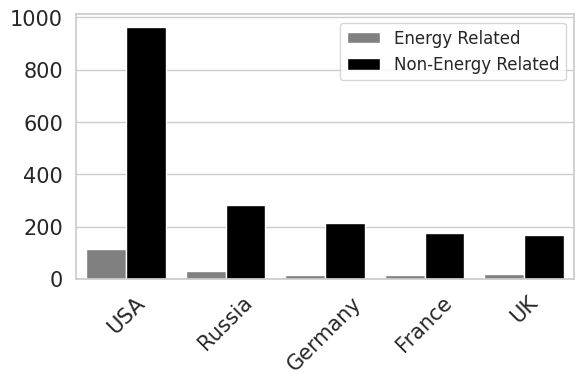

Before deduplication: 42
After deduplication: 0


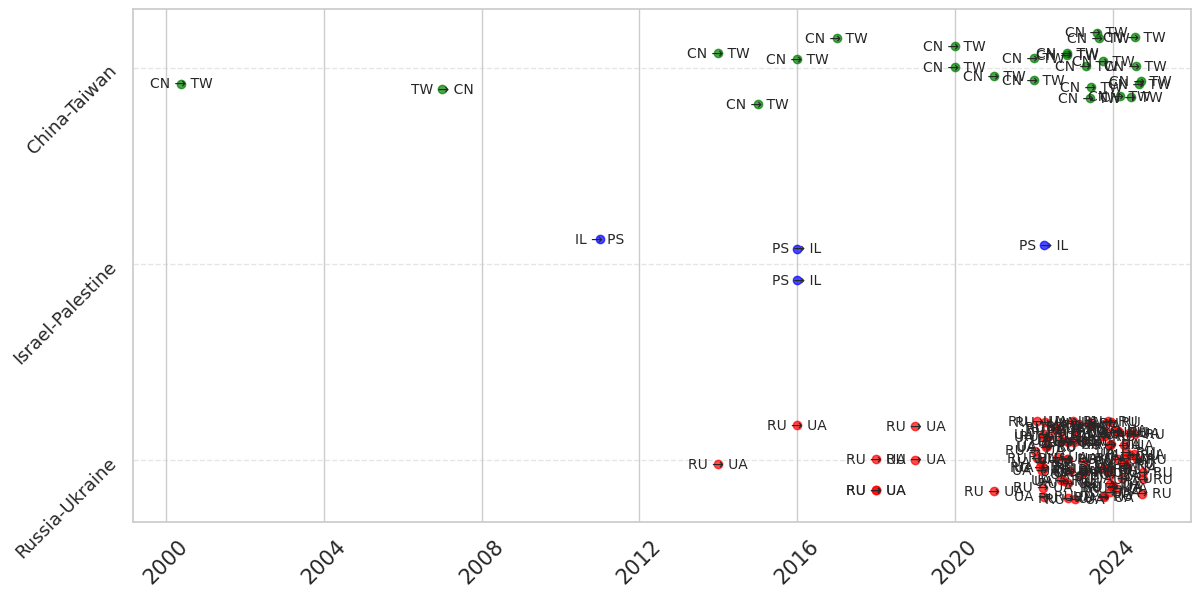

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a seaborn style (optional)
sns.set_theme(style="whitegrid")

# -----------------------------------------------------------------------------
# Data Loading: Read the Excel file
# -----------------------------------------------------------------------------
excel_filepath = "eurepoc_data_2024-12-04T08_57.xlsx"

# List of date columns
date_cols = ["start_date", "end_date", "attribution_date", 
             "political_response_date", "legal_response_date", "updated_at"]

# Read the Excel file and parse the date columns
df = pd.read_excel(excel_filepath, parse_dates=date_cols)


# -----------------------------------------------------------------------------
# Mappings and Helper Functions
# -----------------------------------------------------------------------------

# Mapping to standardize country names
country_aliases = {
    "United States": "USA",
    "U.S.": "USA",
    "US": "USA",
    "U.S.A.": "USA",
    "America": "USA",
    "United Kingdom": "UK",
    "Great Britain": "UK",
    "Korea, Democratic People's Republic of": "North Korea",
    "Iran, Islamic Republic of": "Iran",
    "Korea, Republic of": "South Korea"
}

# Mapping for flag emojis (or country codes used for flag lookup)
flag_emojis = {
    "USA": "US",
    "UK": "GB",
    "Russia": "RU",
    "Ukraine": "UA",
    "Israel": "IL",
    "Palestine": "PS",
    "China": "CN",
    "Taiwan": "TW"
}

def standardize_country_name(country):
    """Return the standardized country name based on known aliases."""
    if isinstance(country, str):
        country = country.strip()
        return country_aliases.get(country, country)
    return None

def clean_country(x):
    """
    Clean a country value and return a standardized name.
    Returns None if the string is empty or a placeholder.
    """
    if isinstance(x, str):
        if x.strip().lower() in ["not available", "unknown", ""]:
            return None
        return standardize_country_name(x)
    return None

def split_and_clean_countries(cell):
    """
    Given a cell (string) that contains country names separated by semicolons,
    split the string by the semicolon, clean each part using clean_country(),
    and return a list of valid country names.
    """
    if isinstance(cell, str):
        parts = [part.strip() for part in cell.split(";") if part.strip()]
        cleaned = [clean_country(part) for part in parts]
        # Filter out any None values (placeholders) and return the list.
        return [x for x in cleaned if x is not None]
    return []

# -----------------------------------------------------------------------------
# Pre-Processing: Clean Country Columns & Simplify Dates
# -----------------------------------------------------------------------------

# Use the new function to split by semicolons
df["initiator_country_clean"] = df["initiator_country"].apply(split_and_clean_countries)
df["receiver_country_clean"] = df["receiver_country"].apply(split_and_clean_countries)

# Create an 'incident_date' column:
# Prefer 'attribution_date' if available; otherwise, use 'start_date'
df["incident_date"] = df["attribution_date"].combine_first(df["start_date"])
# Convert the incident date to a date (dropping the time) for simpler plotting
df["incident_date"] = pd.to_datetime(df["incident_date"], errors="coerce").dt.date

# -----------------------------------------------------------------------------
# Energy-Related Flag
# -----------------------------------------------------------------------------
# Set the energy-related flag by checking if "receiver_category_subcode" contains "energy"
df["energy_related"] = df["receiver_category_subcode"].astype(str).str.contains("energy", case=False, na=False)

# -----------------------------------------------------------------------------
# Analysis Functions
# -----------------------------------------------------------------------------
def debug_duplicates(df):
    """ Check for duplicate entries in the dataset after processing. """
    df_conflict = df[
        (df["initiator_country_clean"].apply(lambda x: isinstance(x, list) and len(x) > 0)) &
        (df["receiver_country_clean"].apply(lambda x: isinstance(x, list) and len(x) > 0)) &
        (df["incident_date"].notnull())
    ].copy()
    
    # Explode multiple country fields
    df_conflict = df_conflict.explode("initiator_country_clean").explode("receiver_country_clean")

    # Standardize names
    df_conflict["initiator_country_clean"] = df_conflict["initiator_country_clean"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x
    )
    df_conflict["receiver_country_clean"] = df_conflict["receiver_country_clean"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x
    )

    # Find duplicate entries
    duplicate_rows = df_conflict[df_conflict.duplicated(subset=["incident_date", "initiator_country_clean", "receiver_country_clean"], keep=False)]
    
    if duplicate_rows.empty:
        print("\nNo duplicates found in the dataset.")
    else:
        print("\nDuplicate entries detected:")
        print(duplicate_rows)


    print("Before deduplication:", df_conflict.duplicated(subset=["ID"]).sum())
    df_conflict = df_conflict.drop_duplicates(subset=["ID"], keep="first")
    print("After deduplication:", df_conflict.duplicated(subset=["ID"]).sum())
# Run the debug function
debug_duplicates(df)



def analyze_geopolitical_alignments(df):
    """
    Analyze incidents by geopolitical alliances based on the initiator country.
    Produces a bar chart showing the count of incidents for each alliance,
    with bars split by energy-related status in a style consistent with 'analyze_threat_origins_targets'.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(style="whitegrid")

    alliances = {
        "NATO": [
            "Albania", "Belgium", "Bulgaria", "Canada", "Croatia", "Czechia", "Denmark",
            "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Iceland",
            "Italy", "Latvia", "Lithuania", "Luxembourg", "Montenegro", "Netherlands",
            "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "Slovakia",
            "Slovenia", "Spain", "Sweden", "Türkiye", "UK", "USA"
        ],
        "BRICS": [
            "China", "Russia", "India", "Brazil", "South Africa", "Egypt",
            "Ethiopia", "Indonesia", "Iran", "United Arab Emirates"
        ],
    }
    
    # Filter rows that have at least one valid initiator country
    df_valid = df[df["initiator_country_clean"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()
    
    # Explode the list so each row has one country
    df_valid = df_valid.explode("initiator_country_clean")
    
    # Standardize and remove empty/NaN
    df_valid["initiator_country_clean"] = df_valid["initiator_country_clean"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else None
    )
    df_valid = df_valid.dropna(subset=["initiator_country_clean"])
    
    # Determine alliance membership based on the origin country
    def find_alliance(country):
        for alliance_name, members in alliances.items():
            if country in members:
                return alliance_name
        return "Other"
    
    df_valid["alliance"] = df_valid["initiator_country_clean"].apply(find_alliance)
    
    # Convert boolean energy_related to a string column for consistent labeling
    df_valid["energy_status"] = df_valid["energy_related"].map({
        True: "Energy Related",
        False: "Non-Energy Related"
    })
    
    # Plot in a similar style to 'analyze_threat_origins_targets'
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(
        data=df_valid,
        x="alliance",
        hue="energy_status",
        palette={"Energy Related": "grey", "Non-Energy Related": "black"}
    )
    
    # Remove big title, use consistent labeling
    plt.xlabel("", fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.xticks(fontsize=15, rotation=45)
    plt.yticks(fontsize=15)
    
    # Simplify legend
    plt.legend(title="", fontsize=12)
    
    plt.tight_layout()
    plt.savefig("alliances_origin_eurepoc.pdf")
    plt.show()

    ####

        # Filter rows that have at least one valid receiver country.
    df_valid = df[df["receiver_country_clean"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()
    
    # Explode the list so that each row has one country.
    df_valid = df_valid.explode("receiver_country_clean")
    
    # Standardize the country names and filter out empty values.
    df_valid["receiver_country_clean"] = df_valid["receiver_country_clean"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else None
    )
    df_valid = df_valid.dropna(subset=["receiver_country_clean"])
    
    # Determine alliance membership based on the target country.
    def find_alliance(country):
        for alliance_name, members in alliances.items():
            if country in members:
                return alliance_name
        return "Other"
    
    df_valid["alliance"] = df_valid["receiver_country_clean"].apply(find_alliance)
    
    # Convert boolean energy_related to a string column.
    df_valid["energy_status"] = df_valid["energy_related"].map({
        True: "Energy Related",
        False: "Non-Energy Related"
    })
    
    # Plot the target data.
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(
        data=df_valid,
        x="alliance",
        hue="energy_status",
        palette={"Energy Related": "grey", "Non-Energy Related": "black"}
    )
    plt.xlabel("", fontsize=15)
    plt.ylabel("Incident Count", fontsize=15)
    plt.xticks(fontsize=15, rotation=45)
    plt.yticks(fontsize=15)
    plt.legend(title="", fontsize=12)
    plt.tight_layout()
    plt.savefig("alliances_targets_eurepoc.pdf")
    plt.show()

def analyze_energy_export_dependence(df):
    """
    Analyze the relationship between energy-exporting nations and threat origination.
    """
    energy_exporters = ["Russia", "Saudi Arabia", "Iran", "Venezuela", "USA", "Canada"]
    
    df_valid = df[df["initiator_country_clean"].apply(lambda x: len(x) > 0)].copy()
    df_valid = df_valid.explode("initiator_country_clean")
    df_valid["initiator_country_clean"] = df_valid["initiator_country_clean"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x
    )
    df_valid = df_valid.dropna(subset=["initiator_country_clean"])
    df_valid = df_valid[df_valid["initiator_country_clean"] != ""]
    # Flag if the country is an energy exporter
    df_valid["energy_exporter"] = df_valid["initiator_country_clean"].apply(lambda x: x in energy_exporters)
    
    plt.figure(figsize=(10, 5))
    order = df_valid["energy_exporter"].value_counts().index
    sns.countplot(data=df_valid, x="energy_exporter", hue="energy_related", order=order)
    plt.title("Energy-Exporting Nations and Threat Origination")
    plt.xlabel("Energy Exporter")
    plt.ylabel("Incident Count")
    plt.xticks(ticks=[0, 1], labels=["Non-Exporter", "Exporter"])
    plt.show()


def analyze_threat_origins_targets(df):
    """
    Analyze threat origins and targets, showing the top 5 countries by total incident count
    (aggregated over both energy-related and non-energy-related detections) for both initiators and receivers.
    For each country, the counts are split by energy-related status.
    """
    #### Process Origins ####
    df_origin = df.copy()
    # Ensure initiator_country_clean is a list; explode it.
    df_origin["initiator_country_clean"] = df_origin["initiator_country_clean"].apply(lambda x: x if isinstance(x, list) else [])
    df_origin = df_origin.explode("initiator_country_clean")
    df_origin["initiator_country_clean"] = df_origin["initiator_country_clean"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x
    )
    df_origin = df_origin.dropna(subset=["initiator_country_clean"])
    df_origin = df_origin[df_origin["initiator_country_clean"] != ""]
    
    # Aggregate counts by country.
    origin_agg = df_origin.groupby("initiator_country_clean").agg(
        total = ("initiator_country_clean", "count"),
        energy_true = ("energy_related", lambda x: (x==True).sum()),
        energy_false = ("energy_related", lambda x: (x==False).sum())
    ).reset_index()
    
    # Sort by total count descending and take the top 5.
    top5_origin = origin_agg.sort_values("total", ascending=False).head(5)
    
    # Melt the data so that we have a column for energy status.
    top5_origin_melt = top5_origin.melt(
        id_vars=["initiator_country_clean", "total"],
        value_vars=["energy_true", "energy_false"],
        var_name="energy_status", value_name="count"
    )
    top5_origin_melt["energy_status"] = top5_origin_melt["energy_status"].map({
        "energy_true": "Energy Related",
        "energy_false": "Non-Energy Related"
    })
    
    # Plot origins.
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(
        data=top5_origin_melt,
        x="initiator_country_clean",
        y="count",
        hue="energy_status",
        palette={"Energy Related": "grey", "Non-Energy Related": "black"}
    )
    #plt.title("Top 5 Threat Origins by Count", fontsize=16)
    plt.xlabel("", fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(title="", fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.savefig("origins_eurepoc.pdf")
    plt.show()
    
    #### Process Targets ####
    df_target = df.copy()
    # Ensure receiver_country_clean is a list; explode it.
    df_target["receiver_country_clean"] = df_target["receiver_country_clean"].apply(lambda x: x if isinstance(x, list) else [])
    df_target = df_target.explode("receiver_country_clean")
    df_target["receiver_country_clean"] = df_target["receiver_country_clean"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x
    )
    df_target = df_target.dropna(subset=["receiver_country_clean"])
    df_target = df_target[df_target["receiver_country_clean"] != ""]
    
    # Aggregate counts by target country.
    target_agg = df_target.groupby("receiver_country_clean").agg(
        total = ("receiver_country_clean", "count"),
        energy_true = ("energy_related", lambda x: (x==True).sum()),
        energy_false = ("energy_related", lambda x: (x==False).sum())
    ).reset_index()
    
    # Sort by total count descending and take the top 5.
    top5_target = target_agg.sort_values("total", ascending=False).head(5)
    
    # Melt the target data.
    top5_target_melt = top5_target.melt(
        id_vars=["receiver_country_clean", "total"],
        value_vars=["energy_true", "energy_false"],
        var_name="energy_status", value_name="count"
    )
    top5_target_melt["energy_status"] = top5_target_melt["energy_status"].map({
        "energy_true": "Energy Related",
        "energy_false": "Non-Energy Related"
    })
    
    # Plot targets.
    plt.figure(figsize=(6, 4))
    ax2 = sns.barplot(
        data=top5_target_melt,
        x="receiver_country_clean",
        y="count",
        hue="energy_status",
        palette={"Energy Related": "grey", "Non-Energy Related": "black"}
    )
    #plt.title("Top 5 Threat Targets by Count", fontsize=16)
    plt.xlabel("", fontsize=15)
    plt.ylabel("", fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(title="", fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.savefig("targets_eurepoc.pdf")
    plt.show()

def analyze_conflict_related_threats(df):
    """
    Plot a timeline of incidents in predefined conflict regions.
    An incident is considered conflict-related if both the initiator and receiver
    belong to a given conflict region.
    
    Dates are simplified to show only the date (without the time).
    """
    conflict_regions = {
        "Russia-Ukraine": ["Russia", "Ukraine"],
        "Israel-Palestine": ["Israel", "Palestine"],
        "China-Taiwan": ["China", "Taiwan"]
    }
    
    # Keep rows with non-empty lists and a valid incident_date
    df_conflict = df[
        (df["initiator_country_clean"].apply(lambda x: len(x) > 0)) &
        (df["receiver_country_clean"].apply(lambda x: len(x) > 0)) &
        (df["incident_date"].notnull())
    ].copy()
    
    # Explode both origin and target lists
    df_conflict = df_conflict.explode("initiator_country_clean").explode("receiver_country_clean")
    df_conflict["initiator_country_clean"] = df_conflict["initiator_country_clean"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x
    )
    df_conflict["receiver_country_clean"] = df_conflict["receiver_country_clean"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x
    )
    
    df_conflict = df_conflict.dropna(subset=["initiator_country_clean", "receiver_country_clean"])
    # Exclude self-attacks
    df_conflict = df_conflict[df_conflict["initiator_country_clean"] != df_conflict["receiver_country_clean"]]
    
    def get_conflict(row):
        for conflict, countries in conflict_regions.items():
            if (row["initiator_country_clean"] in countries) and (row["receiver_country_clean"] in countries):
                return conflict
        return None
    
    df_conflict["conflict"] = df_conflict.apply(get_conflict, axis=1)
    df_conflict = df_conflict.dropna(subset=["conflict"])
    df_conflict = df_conflict.sort_values("incident_date")

    print("Before deduplication:", df_conflict.duplicated(subset=["ID"]).sum())
    df_conflict = df_conflict.drop_duplicates(subset=["ID"], keep="first")
    print("After deduplication:", df_conflict.duplicated(subset=["ID"]).sum())
    
    plt.figure(figsize=(12, 6))
    colors = {"Russia-Ukraine": "red", "Israel-Palestine": "blue", "China-Taiwan": "green"}
    # Fixed y-axis positions for each conflict region
    y_positions = {"Russia-Ukraine": 1, "Israel-Palestine": 2, "China-Taiwan": 3}
    
    for _, row in df_conflict.iterrows():
        conflict = row["conflict"]
        y_offset = y_positions[conflict] + np.random.uniform(-0.2, 0.2)
        plt.scatter(row["incident_date"], y_offset, color=colors.get(conflict, "gray"), alpha=0.7)
        flag_origin = flag_emojis.get(row["initiator_country_clean"], row["initiator_country_clean"])
        flag_target = flag_emojis.get(row["receiver_country_clean"], row["receiver_country_clean"])
        plt.text(row["incident_date"], y_offset, f"{flag_origin} → {flag_target}",
                 fontsize=10, ha='center', va='center')
    
    plt.yticks(list(y_positions.values()), list(y_positions.keys()))
    #plt.xlabel("Date")
    #plt.ylabel("Conflict Region")
    #plt.title("Chronological Order of Attacks in Conflicts (EuRepoC)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=13)
    plt.savefig("current_conflics_eurepoc.pdf")
    plt.show()


def analyze_conflict_related_threats_energy(df):
    """
    Identify and print energy-related incidents that are linked to ongoing conflicts:
    - Russia-Ukraine
    - Israel-Palestine
    - China-Taiwan
    """
    conflict_regions = {
        "Russia-Ukraine": ["Russia", "Ukraine"],
        "Israel-Palestine": ["Israel", "Palestine"],
        "China-Taiwan": ["China", "Taiwan"]
    }

    # Ensure we are only working with valid incidents
    df_conflict = df[
        (df["initiator_country_clean"].apply(lambda x: isinstance(x, list) and len(x) > 0)) &
        (df["receiver_country_clean"].apply(lambda x: isinstance(x, list) and len(x) > 0)) &
        (df["incident_date"].notnull())
    ].copy()


    # Explode country lists for proper mapping
    df_conflict = df_conflict.explode("initiator_country_clean").explode("receiver_country_clean")
    df_conflict["initiator_country_clean"] = df_conflict["initiator_country_clean"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x
    )
    df_conflict["receiver_country_clean"] = df_conflict["receiver_country_clean"].apply(
        lambda x: standardize_country_name(x) if pd.notna(x) and x != "" else x
    )
    # print("Before deduplication:", df_conflict.duplicated(subset=["ID"]).sum())
    # df_conflict = df_conflict.drop_duplicates(subset=["ID"], keep="first")
    # print("After deduplication:", df_conflict.duplicated(subset=["ID"]).sum())
    # Exclude self-initiated attacks (same country as initiator and receiver)
    df_conflict = df_conflict[df_conflict["initiator_country_clean"] != df_conflict["receiver_country_clean"]]

    # Assign each incident to a conflict region if applicable
    def get_conflict(row):
        for conflict, countries in conflict_regions.items():
            if (row["initiator_country_clean"] in countries) and (row["receiver_country_clean"] in countries):
                return conflict
        return None

    df_conflict["conflict"] = df_conflict.apply(get_conflict, axis=1)
    df_conflict = df_conflict.dropna(subset=["conflict"])  # Keep only conflict-related incidents

    # Filter for energy-related incidents
    df_conflict_energy = df_conflict[df_conflict["energy_related"]]



    # Print the results
    print("\nEnergy-Related Cyber Incidents in Current Conflicts:")
    if df_conflict_energy.empty:
        print("No energy-related incidents found in the dataset for these conflicts.")
    else:
        for _, row in df_conflict_energy.iterrows():
            print(f"- Date: {row['incident_date']}, Conflict: {row['conflict']}, "
                  f"Initiator: {row['initiator_country_clean']}, Target: {row['receiver_country_clean']}")

# Run the analysis function
analyze_conflict_related_threats_energy(df)


# -----------------------------------------------------------------------------
# Run All Analyses
# -----------------------------------------------------------------------------

analyze_geopolitical_alignments(df)
analyze_energy_export_dependence(df)
analyze_threat_origins_targets(df)
analyze_conflict_related_threats(df)

In [ ]:
#%pip install -U -q "google-generativeai>=0.8.3"
import typing_extensions as typing
import google.generativeai as genai
from IPython.display import HTML, Markdown, display
genai.configure(api_key='')
from typing_extensions import TypedDict, List
import json
import time
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Define the schema for the Gemini model output
class ThreatParser(TypedDict):
    origin_country: str
    target_country: List[str]
    energy_domain_related: bool

# Load the Excel file
excel_filepath = "eurepoc_data_2024-12-04T08_57.xlsx"
date_cols = ["start_date", "end_date", "attribution_date", 
             "political_response_date", "legal_response_date", "updated_at"]
df = pd.read_excel(excel_filepath, parse_dates=date_cols)

# Set the energy-related flag by checking if "receiver_category_subcode" contains "energy"
df["energy_related"] = df["receiver_category_subcode"].astype(str).str.contains("energy", case=False, na=False)

# Select 100 energy-related and 100 non-energy-related samples with valid descriptions
df_energy = df[df["energy_related"] == True].dropna(subset=["description"]).sample(n=100, random_state=42)
df_non_energy = df[df["energy_related"] == False].dropna(subset=["description"]).sample(n=100, random_state=42)

# Combine into a single dataframe with ground truth labels
eval_df = pd.concat([df_energy, df_non_energy], ignore_index=True)
eval_df = eval_df[["description", "energy_related"]]
eval_df.reset_index(drop=True, inplace=True)

# Initialize the Gemini model with the specified configuration
model = genai.GenerativeModel(
    'gemini-1.5-flash-latest',
    generation_config=genai.GenerationConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=ThreatParser,
    )
)

# Calculate the delay between each API call to distribute calls over 5 minutes (300 seconds)
total_time = 2000  # 5 minutes in seconds
num_samples = len(eval_df)  # Should be 200 samples
delay_between_calls = total_time / num_samples

# Process each description, call the Gemini model, and store predictions
results = []
correct = 0

print("Starting evaluation over {} samples...".format(num_samples))
for idx, row in eval_df.iterrows():
    description = row["description"]
    ground_truth = row["energy_related"]
    
    try:
        response = model.generate_content(description)
        parsed_output = json.loads(response.text)  # Expecting a dict with key "energy_domain_related"
        predicted = parsed_output.get("energy_domain_related", None)
        
        # Compare predicted value with ground truth
        if predicted is not None and bool(predicted) == ground_truth:
            correct += 1
        
        results.append({
            "description": description,
            "ground_truth_energy": ground_truth,
            "predicted_energy": predicted,
            "response": parsed_output
        })
    except Exception as e:
        results.append({
            "description": description,
            "ground_truth_energy": ground_truth,
            "error": str(e)
        })
    
    print(f"Processed sample {idx+1}/{num_samples}")
    if idx < num_samples - 1:
        time.sleep(delay_between_calls)

# Compute accuracy
accuracy = correct / num_samples * 100
print(f"\nEvaluation completed. Accuracy: {accuracy:.2f}%")

# Optionally, save the detailed results to a JSON file
output_file = "gemini_energy_evaluation_results.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=2)

print(f"Detailed results saved to {output_file}")


/scratch/slurm_tmpdir/job_1509288/ipykernel_3626395/1333605755.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_excel(excel_filepath, parse_dates=date_cols)


Starting evaluation over 200 samples...
Processed sample 1/200
Processed sample 2/200


Evaluation Accuracy: 84.00%
Confusion Matrix:
[[91  9]
 [23 77]]


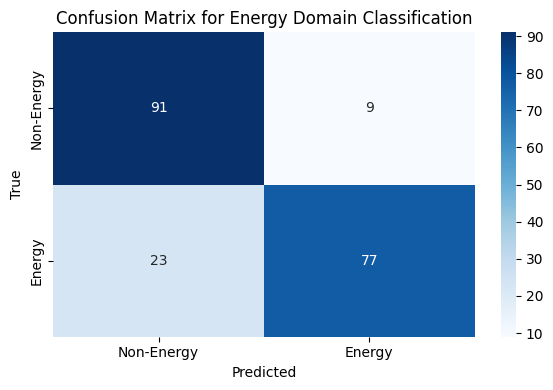

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the evaluation JSON file
with open("gemini_energy_evaluation_results.json", "r") as f:
    results = json.load(f)

# Convert the results to a DataFrame
df_results = pd.DataFrame(results)

# If there are any rows with errors, filter them out for analysis
if "error" in df_results.columns:
    df_clean = df_results[df_results["error"].isnull()].copy()
else:
    df_clean = df_results.copy()

# Ensure ground truth and predicted values are booleans
df_clean["ground_truth_energy"] = df_clean["ground_truth_energy"].astype(bool)
df_clean["predicted_energy"] = df_clean["predicted_energy"].astype(bool)

# Compute correctness for each prediction
df_clean["correct"] = df_clean.apply(lambda row: row["ground_truth_energy"] == row["predicted_energy"], axis=1)

# Calculate accuracy as a percentage
accuracy = df_clean["correct"].mean() * 100
print("Evaluation Accuracy: {:.2f}%".format(accuracy))

# Create a confusion matrix
y_true = df_clean["ground_truth_energy"]
y_pred = df_clean["predicted_energy"]
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Energy", "Energy"],
            yticklabels=["Non-Energy", "Energy"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Energy Domain Classification")
plt.tight_layout()
plt.show()
